Begin by creating two list of files: one with interictals and another with preictals.

In [1]:
import os
import re
import numpy as np

In [2]:
dir_path = '../../data.nosync'

def is_interictal(name):
    return 'interictal' in name

interictal_filter = filter(is_interictal, os.listdir(dir_path))
interictals = [interictal for interictal in interictal_filter]
print(len(interictals))
interictals[:5]

480


['Dog_1_interictal_segment_0085.mat',
 'Dog_1_interictal_segment_0091.mat',
 'Dog_1_interictal_segment_0046.mat',
 'Dog_1_interictal_segment_0052.mat',
 'Dog_1_interictal_segment_0287.mat']

In [3]:
def is_preictal(name):
    return 'preictal' in name

preictal_filter = filter(is_preictal, os.listdir(dir_path))
preictals = [preictal for preictal in preictal_filter]
print(len(preictals))
preictals[:5]

24


['Dog_1_preictal_segment_0023.mat',
 'Dog_1_preictal_segment_0022.mat',
 'Dog_1_preictal_segment_0020.mat',
 'Dog_1_preictal_segment_0008.mat',
 'Dog_1_preictal_segment_0009.mat']

The preprocessing pipeline will load a signal as input, apply STFT on each of the 16 channels individually and output 16 $k \times l$ matrices representing STFT of input. 

In [4]:
from scipy.io import loadmat

In [5]:
file_path = dir_path + '/' + interictals[0]
mat = loadmat(file_path)
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Thu Aug 21 01:00:00 2014',
 '__version__': '1.0',
 '__globals__': [],
 'interictal_segment_85': array([[(array([[ 16,  16,  15, ..., -22, -13,  -2],
        [ 19,  13,   5, ...,  -9, -11, -14],
        [ 24,  24,  27, ...,   4,   4,   2],
        ...,
        [ -4,  -5,   1, ..., -13, -15, -21],
        [-36, -28, -23, ..., -22, -29, -35],
        [-20, -21, -16, ...,   4,   1,  -2]], dtype=int16), array([[600]], dtype=uint16), array([[399.6097561]]), array([[array(['NVC1202_32_002_Ecog_c001'], dtype='<U24'),
         array(['NVC1202_32_002_Ecog_c002'], dtype='<U24'),
         array(['NVC1202_32_002_Ecog_c003'], dtype='<U24'),
         array(['NVC1202_32_002_Ecog_c004'], dtype='<U24'),
         array(['NVC1202_32_002_Ecog_c005'], dtype='<U24'),
         array(['NVC1202_32_002_Ecog_c006'], dtype='<U24'),
         array(['NVC1202_32_002_Ecog_c007'], dtype='<U24'),
         array(['NVC1202_32_002_Ecog_c008'], dtype='<U24'

Note: It seems the sampling frequency isn't exactly 400Hz. The impact of this on the output dimensions of STFT matrix should be explored.

In [6]:
def get_sig(mat):
    "Returns (channel x times) matrix representing EEG signal in microvolt."
    segment_name = list(mat.keys())[-1]
    segment = mat[segment_name]
    sig = segment['data'][0][0]
    return sig

def get_fs(mat):
    "Returns the sampling frequency."
    segment_name = list(mat.keys())[-1]
    segment = mat[segment_name]
    fs = segment['sampling_frequency'][0][0][0][0]
    return fs

In [7]:
sigbuf = get_sig(mat)
sigbuf.shape

(16, 239766)

In [8]:
# rounding off sampling rate
fs = np.round(get_fs(mat))
fs

400.0

In [9]:
# first signal row corresponds to channel 'NVC1202_32_002_Ecog_c001'
c001_sig = sigbuf[0,:]
c001_sig.shape

(239766,)

In [10]:
import matplotlib.pyplot as plt

(-800.0, 800.0)

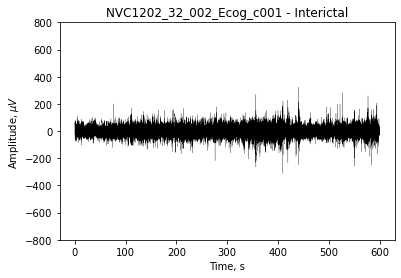

In [11]:
# plot this channel
N = len(c001_sig)
t = np.arange(0, N) / fs
fig, ax = plt.subplots()
ax.plot(t, c001_sig, color='k', linewidth=.2)
ax.set_title('NVC1202_32_002_Ecog_c001 - Interictal')
ax.set_xlabel('Time, s')
ax.set_ylabel('Amplitude, $\mu V$')
ax.set_ylim([-800.0, 800.0])

In [12]:
from scipy import signal

800


Text(0, 0.5, '$\\log_{10}$ Power')

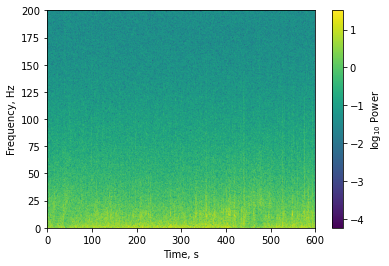

In [13]:
# produce spectrogram of the 600s interictal period using STFT with 2s sliding Hann window with 50% overlap
timewin = 2
timewinidx = np.rint(timewin/(1/fs)).astype(int)
print(timewinidx)

f, t, Zxx = signal.stft(c001_sig, fs=fs, window='hann', nperseg=timewinidx, noverlap=None, return_onesided=True)

fig, ax = plt.subplots()
mesh = ax.pcolormesh(t, f, np.log10(np.abs(Zxx)), shading='gouraud')
ax.set_xlabel('Time, s')
ax.set_ylabel('Frequency, Hz')
cbar = fig.colorbar(mesh)
cbar.ax.set_ylabel('$\log_{10}$ Power')

Comparing input signal matrix dimension with STFT output matrix dimension.

In [14]:
print('In:', c001_sig.shape)
print('Out:', Zxx.shape)

In: (239766,)
Out: (401, 601)


Perform STFT on remaining channels.

In [85]:
# STFT of all channels will be stored here
Zxxs = np.zeros((16, 401, 601), dtype='complex')
Zxxs.shape

(16, 401, 601)

In [86]:
Zxxs[0,:] = Zxx
Zxxs[0,:].shape

(401, 601)

In [88]:
from tqdm import tqdm

In [89]:
for i in tqdm(range(1, sigbuf.shape[0])):
    sig = sigbuf[i,:]
    timewin = 2 # sliding window duration in seconds
    timewinidx = np.rint(timewin/(1/fs)).astype(int)
    f, t, Zxx = signal.stft(sig, fs=fs, window='hann', nperseg=timewinidx, noverlap=None, return_onesided=True)
    Zxxs[i,:] = Zxx

100%|██████████| 15/15 [00:00<00:00, 36.05it/s]


In [96]:
interictals[0].split('.')[0]

'Dog_1_interictal_segment_0085'

In [100]:
import h5py

In [101]:
# save STFT matrix to disk
filename = 'preprocessed_data/Dog_1/' + interictals[0].split('.')[0] + '.h5'
h5f = h5py.File(filename, 'w')
h5f.create_dataset(interictals[0].split('.')[0], data=Zxxs)
h5f.close()

<HDF5 dataset "Dog_1_interictal_segment_0085": shape (16, 401, 601), type "<c16">

This file is 61.7 MB. The input file was 7.67 MB. This is an increase of filesize by 8x which does not make this approach feasible. What could be an alternative method?